In [1]:
%pylab inline
import numpy as np
from scipy.integrate import odeint
import itertools
from SparseARD import*
from Oracle_Training import *
import json
np.random.seed(0)

retrain = False

n_trials = 10
p = 5 # degree of polynomial library
noise_percent = 1

tol = 1e-8 # tolerance for ARD algorithm
verbose = True

Populating the interactive namespace from numpy and matplotlib


In [2]:
def lorenz_ode(X, t, params):
    s,r,b = params
    x,y,z = X
    return [s*(y-x), x*(r-z)-y, x*y-b*z]

n = 3
m = 251
dt = 0.05

t = np.linspace(0,(m-1)*dt,m)

params = (10,28,8.0/3)

In [3]:
feature_maps, feature_descriptions = polynomial_feature_maps(n, p)
d = len(feature_maps)

In [4]:
if retrain:
    
    Xi = [{'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []} for dim in range(n)]
    L1_err = [{'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []} for dim in range(n)]
    L2_err = [{'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []} for dim in range(n)]
    Added = [{'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []} for dim in range(n)]
    Missed = [{'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []} for dim in range(n)]

    for trial in range(n_trials):
    
        print('\nTrial', trial+1, 'of', str(n_trials)+'.')

        # get dataset
        x0 = np.array([0,0,15]) + 5*np.random.randn(3)
        X = odeint(lorenz_ode, x0, t, args=(params,), rtol = 1e-12, atol = 1e-12)

        eps = 0.01*noise_percent*np.std(X)
        measurement_noise = eps*np.random.randn(m,n)
        X_obs = X + measurement_noise

        Theta = np.hstack([f(X_obs) for f in feature_maps])

        for dim in range(n):

            print('Dimension', dim+1, 'of', str(n)+'.')

            # True predictor
            xi_true = np.zeros((len(feature_maps),1))
            if dim == 0:
                xi_true[2,0] = 10
                xi_true[3,0] = -10
            elif dim == 1:
                xi_true[3,0] = 28
                xi_true[7,0] = -1
                xi_true[2,0] = -1
            else:
                xi_true[8,0] = 1
                xi_true[1,0] = -8/3
            xi = xi_true

            y = FiniteDiff(X_obs, dt, 1, 6)[:,dim].reshape(m,1)

            # Test each method
            print('Training ARD.')
            gamma_ARD,sigma2_ARD,mu_xi_ARD,_ = SBL([Theta,y], \
                                               sigma2=1, \
                                               estimate_sigma=True, \
                                               maxit=500, \
                                               verbose=False, \
                                               tol=tol)
            ARD_results = gamma_ARD,sigma2_ARD,mu_xi_ARD

            print('Training ARDr.')
            lams = [np.linalg.norm(y)**2*l for l in [0,1e-1,1e0,1e1,1e2,1e3,1e4]]
            gamma_ARDr, sigma2_ARDr, mu_xi_ARDr = Train_ARDr(Theta,y,\
                                                             xi_true,\
                                                             ARD_results=ARD_results,\
                                                             lams = lams,\
                                                             verbose=verbose)

            print('Training ARDvi.')
            alphas = [1,2,4,8,16,32,64,128,256]
            gamma_ARDvi, sigma2_ARDvi, mu_xi_ARDvi = Train_ARDvi(Theta,y,\
                                                                 xi_true,\
                                                                 ARD_results=ARD_results, \
                                                                 alphas=alphas,\
                                                                 verbose=verbose)

            print('Training STSBL.')
            taus = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
            gamma_STSBL, sigma2_STSBL, mu_xi_STSBL = Train_M_STSBL(Theta,y,\
                                                                   xi_true,\
                                                                   ARD_results=ARD_results,\
                                                                   taus=taus,\
                                                                   verbose=verbose)

            print('Training lSTSBL.')
            taus = [np.inf,1e-8,1e-6,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
            gamma_lSTSBL, sigma2_lSTSBL, mu_xi_lSTSBL = Train_L_STSBL(Theta,y,\
                                                                      xi_true,\
                                                                      ARD_results=ARD_results, \
                                                                      taus=taus,\
                                                                      verbose=verbose)

            print('Training dSTSBL.')
            taus = [0,1e-2,1e-1,1,1e1,1e2,1e3]
            gamma_dSTSBL, sigma2_dSTSBL, mu_xi_dSTSBL = Train_MAP_STSBL(Theta,y,\
                                                                      xi_true,\
                                                                      ARD_results=ARD_results,\
                                                                      taus=taus,\
                                                                      verbose=verbose)

            # Record predictors and errors
            Xi[dim]['ARD'].append(list(mu_xi_ARD.flatten()))
            Xi[dim]['ARDr'].append(list(mu_xi_ARDr.flatten()))
            Xi[dim]['ARDvi'].append(list(mu_xi_ARDvi.flatten()))
            Xi[dim]['mSTSBL'].append(list(mu_xi_STSBL.flatten()))
            Xi[dim]['lSTSBL'].append(list(mu_xi_lSTSBL.flatten()))
            Xi[dim]['dSTSBL'].append(list(mu_xi_dSTSBL.flatten()))
            
            L1_err[dim]['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 1))
            L1_err[dim]['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 1))
            L1_err[dim]['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 1))
            L1_err[dim]['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 1))
            L1_err[dim]['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 1))
            L1_err[dim]['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 1))

            L2_err[dim]['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 2))
            L2_err[dim]['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 2))
            L2_err[dim]['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 2))
            L2_err[dim]['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 2))
            L2_err[dim]['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 2))
            L2_err[dim]['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 2))

            _,added,missed = sparsity_err(mu_xi_ARD,xi)
            Added[dim]['ARD'].append(added)
            Missed[dim]['ARD'].append(missed)

            _,added,missed = sparsity_err(mu_xi_ARDr,xi)
            Added[dim]['ARDr'].append(added)
            Missed[dim]['ARDr'].append(missed)

            _,added,missed = sparsity_err(mu_xi_ARDvi,xi)
            Added[dim]['ARDvi'].append(added)
            Missed[dim]['ARDvi'].append(missed)

            _,added,missed = sparsity_err(mu_xi_STSBL,xi)
            Added[dim]['mSTSBL'].append(added)
            Missed[dim]['mSTSBL'].append(missed)

            _,added,missed = sparsity_err(mu_xi_lSTSBL,xi)
            Added[dim]['lSTSBL'].append(added)
            Missed[dim]['lSTSBL'].append(missed)

            _,added,missed = sparsity_err(mu_xi_dSTSBL,xi)
            Added[dim]['dSTSBL'].append(added)
            Missed[dim]['dSTSBL'].append(missed)

In [5]:
if retrain:
    with open('./saved_results/L63_results.json','w') as f:
        json.dump({'L2_err': L2_err, \
                   'L1_err': L1_err, \
                   'Added' : Added, \
                   'Missed' : Missed, \
                   'Xi' : Xi}, f)
else:
    with open('./saved_results/L63_results.json','r') as f:
        results = json.load(f)
    L2_err = results['L2_err']    
    L1_err = results['L1_err']    
    Added = results['Added']
    Missed = results['Missed']
    Xi = results['Xi']

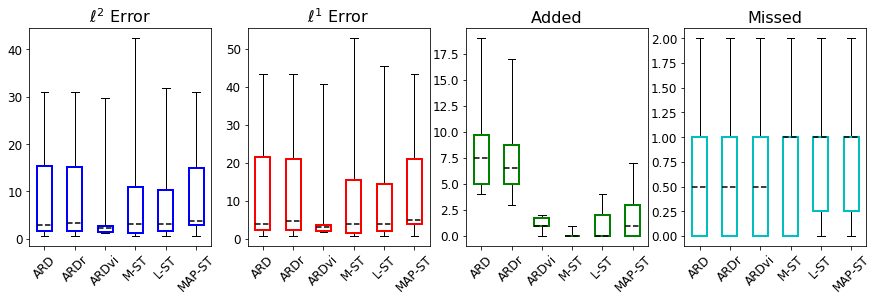

In [6]:
figure(figsize = (15,4))

lw = 2
label_fs = 16

whis = [0,100]
showfliers = False

subplot(1,4,1)
title(r'$\ell^2$ Error', fontsize = 16)
bp1 = boxplot([np.sum([L2_err[dim][key] for dim in range(3)], axis = 0) \
               for key in L2_err[0].keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker,cap in zip(bp1['boxes'], bp1['whiskers'], bp1['caps']):
    box.set(color='blue', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp1['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,2)
title(r'$\ell^1$ Error', fontsize = 16)
bp2 = boxplot([np.sum([L1_err[dim][key] for dim in range(3)], axis = 0) \
               for key in L1_err[0].keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap in zip(bp2['boxes'], bp2['whiskers'], bp2['caps']):
    box.set(color='red', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp2['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,3)
title(r'Added', fontsize = 16)
bp3 = boxplot([np.sum([Added[dim][key] for dim in range(3)], axis = 0) \
               for key in Added[0].keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp3['boxes'], bp3['whiskers'], bp3['caps'], bp3['medians']):
    box.set(color='green', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp3['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,4)
title(r'Missed', fontsize = 16)
bp4 = boxplot([np.sum([Missed[dim][key] for dim in range(3)], axis = 0) \
               for key in Missed[0].keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp4['boxes'], bp4['whiskers'], bp4['caps'], bp4['medians']):
    box.set(color='c', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp4['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)